# **Incognito - Efficient Full-Domain K-Anonymity**

In [ ]:
import pandas as pd
from google.colab import files
from google.colab import drive
from sqlite3 import dbapi2 as sqlite3
import matplotlib.pyplot as plt
import os
from os import path
from sympy import subsets
import argparse
import queue
import numpy as np
import time

<figure>
<center>
<img src="https://i.ibb.co/Yczmkyx/Screenshot-2023-01-02-at-12-56-11.png" width="600" 
     height="400"/>
<figcaption>Figure 8: Basic Incognito algorithm</figcaption></center>
</figure>

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive



# **Step 1** - Data
According to Figure 8, **Inputs** are:
* A table T to be k-anonymized 
* a set Q of n quasi-identifier attributes
* and a set of dimension tables (one for each quasi-identifier in Q)

In [ ]:
print("Enter all the Parameters")
#Get paths:
datasetPath = input("Private Table file Path: ")
quasi_identifiers = input("QI names in order, separate with COMMA: ")
QI_list = list(quasi_identifiers.split(","))
dimPath = dict()
for i, qi_name in enumerate(QI_list):
   dimPath[qi_name] = input(qi_name+ " Dimension Table file Path: ")
K = input("K to Anonymize PT with (more than 0 and less than the number of PT rows): ")
T = input("T to indicate the threshold for suppressing outliers (0 and more, and less than K): ")

Enter all the Parameters
Private Table file Path: /content/drive/MyDrive/Colab Notebooks/DPP/Adults/adults.csv
QI names in order, separate with COMMA: age,occupation,race
age Dimension Table file Path: /content/drive/MyDrive/Colab Notebooks/DPP/Adults/age.csv
occupation Dimension Table file Path: /content/drive/MyDrive/Colab Notebooks/DPP/Adults/occupation.csv
race Dimension Table file Path: /content/drive/MyDrive/Colab Notebooks/DPP/Adults/race.csv
K to Anonymize PT with (more than 0 and less than the number of PT rows): 9
T to indicate the threshold for suppressing outliers (0 and more, and less than K): 3


In [ ]:
# Start SQL
con = sqlite3.connect(":memory:") #We can create a database in memory by using this syntax.
cur = con.cursor()

## Step 1-1 : Prepare the private table

* read the csv file of Dataset
* make a SQL table

In [ ]:
# Read dataset and its attributes:
dataset_file = open(datasetPath)
datasetName = path.basename(datasetPath).split(".")[0]

attributeList = dataset_file.readline().split(",")
attributespace = [a.strip() for a in attributeList] #remove white spaces
attributeNames = [a.replace("-", "_").replace("\n","") for a in attributespace]

dataset = pd.read_csv(datasetPath, sep=',', skipinitialspace = True)
for attr in attributespace:
  proc_attr = attr.strip().replace("-", "_").replace("\n","") #remove white spaces
  dataset = dataset.rename(columns={attr: proc_attr})

dataset = dataset.astype(str)
dataset[attributeNames[:-1]] = dataset[attributeNames[:-1]].replace('-', '_', regex=True) #for Adults only

# Make a sql table from dataframe:
attributeNamesSQL = [a + " TEXT" for a in attributeNames]
dataset.to_sql(datasetName, con, if_exists='append', index = False)

#print(attributeNamesSQL)
#attributeNames = ['id', 'age', 'city_birth', 'zip_code', 'disease'] Adults = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',...]


## Step 1-2 : Prepare the dimensions
* read the csv file of each dimension previously determined by Quasi-identifiers names 
* each table has all the 0th level of hierarchy in first column with the header 0, 1st in second column with header 1, and so on...
* make a SQL table for each

In [ ]:
# For each QI in DimensionNames make a table"
QILevels = list()
for qi_name in QI_list:
# for a single dimension file read from user (ex: age.csv)
    dimension_file_i = open(dimPath[qi_name])
    dimName_i = path.basename(dimPath[qi_name]).split(".")[0]
    print("Generalization file name for Quasi Identifier ", qi_name, " is ", dimName_i)

    QILevels_i = len(dimension_file_i.readline().split(","))

    # if  dimName_i == "city_birth_generalization":
    #     del(dim_i[QILevels_i-1])
    #     QILevels_i = len(dimension_file_i.readline().split(","))-1 #QILevels = [4, 3, 6]

    QILevels.append(QILevels_i) 
    dim_i = pd.read_csv(dimension_file_i, sep="," , header = None) #dimension is now panda dataframe

    dim_i.loc[:,0] = dim_i.loc[:,0].astype('string')

    # Make a SQL table for the corresponding dimension file :
    dim_i.to_sql("gen_of_"+qi_name, con, if_exists='append', index = False)
    print("And its dimension SQL file name is ", "gen_of_"+qi_name) 

print("Generalization Levels: ",QILevels)


Generalization file name for Quasi Identifier  age  is  age
And its dimension SQL file name is  gen_of_age
Generalization file name for Quasi Identifier  occupation  is  occupation
And its dimension SQL file name is  gen_of_occupation
Generalization file name for Quasi Identifier  race  is  race
And its dimension SQL file name is  gen_of_race
Generalization Levels:  [4, 3, 2]


## Step 1-3 : Control input

Control if the user entered correct K and Threshold.

In [ ]:
cur.execute("SELECT * FROM " + datasetName)
k = int(K)
t = int(T)
if k > len(list(cur)):
    print("K should not exceed the number of rows in PT")
    exit(0)
if t >= k:
    print("Threshold should not exceed K")
    exit(0)


# **Step 2** : Iteration
Iterate and perform main PARTS of Figure 8: Basic Incognito algorithm
 
<figure>
<center>
<img src='https://i.ibb.co/j3b23r7/Screenshot-2023-01-02-at-14-49-26.png' width="400" 
     height="300"/>
<figcaption>Loop with two parts</figcaption></center>
</figure>

## Step 2-1 : Initialization

According to Figure 8, Initialize the Graph elements

* C1 = {Nodes in the domain generalization hierarchies of attributes in Q}
* E1 = {Edges in the domain generalization hierarchies of attributes in Q}

used to insert the tuple:    #https://stackoverflow.com/questions/17530783/python-inserting-list-of-tuples-in-sql-database-and-add-an-auto-incrementing-id

<figure>
<center>
<img src="https://i.ibb.co/f2wN52Q/Screenshot-2023-01-02-at-17-49-51.png" width="400" 
     height="150"/>
<figcaption>Figure 6: Representation of sample generalization lattice</figcaption></center>
</figure>
<figure>
<center>
<img src="https://i.ibb.co/PxKhcT3/Screenshot-2023-01-03-at-13-09-56.png" width="350" 
     height="100"/>
<figcaption>How</figcaption></center>

In [ ]:
# Initialize the SQL table C1, E1:
def initialization(QI_list, QILevels):
        
      print("The graph (C and Edges) with nodes of 1 QI is being generated using SQL tables...")
      cur.execute("CREATE TABLE IF NOT EXISTS C1 (ID INTEGER PRIMARY KEY, dim1 TEXT, index1 INT, parent1 INT, parent2 INT)")
      cur.execute("CREATE TABLE IF NOT EXISTS E1 (Start INT, End INT)")
      #Generate graph for 1 quasi-identifiers set

      ID = 1 #unique for each node
      for dimnum, dim in enumerate(QI_list): #for each QI: age for now:
        index = 0 #each dimension can have multiple level index starting from 0.
        for i in range (QILevels[dimnum]):  # for all the levels (4 levels for age)
          parent1 = ID-1 if index > 0 else "null"
          parent2 = "null"
          var = (ID, dim, index, parent1, parent2)
          cur.execute("INSERT INTO C1 values (?, ?, ?, ?, ?)", var) #Nodes
          if index >= 1:
              var = (ID - 1, ID)
              cur.execute("INSERT INTO E1 values (?, ?)", var) #Edges
          ID += 1
          index += 1
      print("Done!")
      print(list(cur.execute("SELECT * FROM C1"))) #[(1, 'age', 0, 'null', 'null'), (2, 'age', 1, 0, 'null'), (3, 'age', 2, 1, 0), (4, 'age', 3, 2, 1),..........]
      print(list(cur.execute("SELECT * FROM E1"))) #[(1, 2), (2, 3), (3, 4), (5, 6), (6, 7), (7, 8), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]


## Step 2-2 : Tools for Part 1
But we need some tools first:

* A function to compute each node's height.
* A function to compute frequency set of T with respect to attributes of node using T.
* A function to compute frequency set of T with respect to attributes of node using parent’s frequency set.
* Check k-anonymity with respect to attributes of node (input:frequencySet)

###Step 2-2-1 : node's height:
* height is sum of the indices in a row (node)
<figure>
<center>
<img src="https://i.ibb.co/wp0gHNc/Screenshot-2023-01-20-at-18-40-19.png" width="400" 
     height="150"/>
<figcaption>How</figcaption></center>

In [ ]:
def node_height(node): # dims are: 2,4,6 TO len-3 -> P1,P2 excluded
    height = 0
    for j in range (2, len(node) -3, 2):
        height += node[j]
    return height

###Step 2-2-2 : root frequencies

A function to compute frequency set of T with respect to attributes of node using T.

In SQL, the frequency set is obtained from T with respect to a set of attributes Q by issuing a COUNT(*) query, with Q as the attribute list in the GROUP BY clause. For example, in order to check whether the Patients table in Figure 1 is 2-anonymous with respect to ⟨Sex, Zipcode⟩, we issue a query SELECT COUNT(*) FROM Patients GROUP BY Sex, Zipcode. Since the result includes groups with count fewer than 2, Patients is not 2-anonymous with respect to ⟨Sex, Zipcode⟩.

In [ ]:
def freq_set_root(node):

    #get the "attributes of node"
    node_attrs = set() # ex: {'age', 'zip_code'}
    node_dimIndexTuples = list() # ex: [('age', 1),('zip_code', 0)]
    for i in range(len(node)-2):
      if i%2 == 1 and node[i] != 'null':
        node_attrs.add(node[i])
        node_dimIndexTuples.append((node[i],node[i+1])) 
    # ex: with [('age', 1), ('zip_code', 0)]
    # From PT, get the number of records that have level of generalization 1(index) for age(dim), and 0 for zip_code
    # I don't need to have a for loop for all the records, SQL COUNT does it for me.
    # ex: COUNT the number of occurances in db_100 and all dimension tables,
    #     WHERE the first attribute value of db_100 (ex: db_100.zip_code) is equal to
    #     the value in the "node's zip_code index: 0" column of corresponding dimension table (zip_code."0")
    #     AND the second ......
    #     Then GROUP BY all the attributes of node
    # SELECT COUNT(*) FROM db_100, age, .... WHERE db_100.age = age."1" GROUP BY age."1"
    dim_Names = list()
    WHERE = list()
    GROUP_BY = set(node_attrs)
    for i in range(len(node_dimIndexTuples)): #Take one tuple at a time to form the Query

        col_in_dataset = node_dimIndexTuples[i][0]
        node_ith_index = node_dimIndexTuples[i][1]
        if node_dimIndexTuples[i][0] == "null" or node_dimIndexTuples[i][1] == "null":
           continue
        if col_in_dataset in node_attrs:
            GROUP_BY.remove(col_in_dataset)
            GROUP_BY.add("gen_of_"+col_in_dataset + ".\"" + str(node_ith_index) + "\"")
        dim_Names.append("gen_of_"+col_in_dataset) #list of dimension tables to be joined together
        WHERE_of_tuple = "" + datasetName + "." + col_in_dataset + " = " + "gen_of_"+col_in_dataset + ".\"0\"" 
        WHERE.append(WHERE_of_tuple) #['db_100.age = age."0"' , ...]

    #execute the formed query:
    #column 0 of dimension table is enough Because we are calculating a root's freq
    cur.execute("SELECT COUNT(*) FROM " + datasetName + ", " + ', '.join(dim_Names) +
                " WHERE " + 'and '.join(WHERE) +
                " GROUP BY " + ', '.join(GROUP_BY))
    
    # make the frequency set:
    freq_set = list()
    for occur in list(cur):
        freq_set.append(occur[0]) # (3,)
    return freq_set

# node_attrs: ['age']
# WHERE: ['db_100.age = age."0"' , ...]
# SELECT COUNT(*) FROM db_100, age WHERE db_100.age = age."0" GROUP BY age."0"

###Step 2-2-3 : non-root frequencies

A function to compute frequency set of T with respect to attributes of node using parent’s frequency set.

In [ ]:
def freq_set_nonroot(node):
    #print("node nonroot", node)
    #get the "attributes of node"
    node_attrs = set() # ex: {'age', 'zip_code'}
    node_dimIndexTuples = list() # ex: [('age', 1),('zip_code', 0)]
    for i in range(len(node)-2):
      if i%2 == 1 and node[i] != 'null':
        node_attrs.add(node[i])
        node_dimIndexTuples.append((node[i],node[i+1])) 

    dim_Names = list() 
    SELECT = list()
    WHERE = list() 
    GROUP_BY = set(node_attrs)

    cur.execute("CREATE TABLE CountOfNode (count INT, " + ', '.join(node_attrs) + ")")

    for i in range(len(node_dimIndexTuples)):#Take one tuple at a time to form the Query

        col_in_dataset = node_dimIndexTuples[i][0]
        node_ith_index = node_dimIndexTuples[i][1]

        if col_in_dataset in node_attrs: #<<<HELP>>>
            GROUP_BY.remove(col_in_dataset)
            GROUP_BY.add("gen_of_"+col_in_dataset + ".\"" + str(node_ith_index) + "\"")    
        dim_Names.append("gen_of_"+col_in_dataset) #list of dimension tables to be joined together
        WHERE_of_tuple = "" + datasetName + "." + col_in_dataset + " = " + "gen_of_"+col_in_dataset + ".\"0\"" 
        WHERE.append(WHERE_of_tuple) #['db_100.age = age."0"' , ...]
        #column "node's attribute's index" of dimension table should be selected:
        SELECT_of_tuple = "gen_of_"+col_in_dataset + ".\"" + str(node_ith_index) + "\" AS " + col_in_dataset
        SELECT.append(SELECT_of_tuple) #['age."1" AS age' , ...]

    cur.execute("INSERT INTO CountOfNode"
                   " SELECT COUNT(*) AS count, " + ', '.join(SELECT) +
                   " FROM " + datasetName + ", " + ', '.join(dim_Names) +
                   " WHERE " + 'AND '.join(WHERE) +
                   " GROUP BY " + ', '.join(GROUP_BY))
    
    cur.execute("SELECT SUM(count) FROM CountOfNode GROUP BY " + ', '.join(node_attrs))
    results = list(cur)

    # make the frequency set:
    freq_set = list()
    for occur in results:
        freq_set.append(occur[0]) # (3,)

    # erase for next loop:    
    cur.execute("DROP TABLE CountOfNode")
    return freq_set

###Step 2-2-4 : K-Anonymity Check

Use frequencySet to check k-anonymity with respect to attributes of node.

In [ ]:
def kAnonymity_wrt_node_attr(freq_set): # <<<HELP>>>
  if len(freq_set) == 0:
      return False
  for freq in freq_set:
      if type(freq) == tuple:
          freq = freq[0]
      if freq<k and freq>t: # in case it is =< t, the anonymity is not false, instead, it should be removed later
          return False # PT is not anonymous wrt this node, otherwise, still check other freqs
  return True

##Step 2-3 :  Part 2

Implement the part 2 of Basic Incognito which is mentioned in Figure 8 as "Ci+1,Ei+1 = GraphGeneration(Si, Ei)"

And is explained below in 2 PHASES:

<table align = "ceter">
        <tr>
            <td rowspan="2"><figure><center><img src="https://i.ibb.co/0Y8yW34/Screenshot-2023-01-03-at-12-43-20.png" width="450" height="380"/><figcaption>Phase 1</figcaption></center>
</figure></td>
            <td><figure><center><img src="https://i.ibb.co/fGqK40K/Screenshot-2023-01-03-at-12-43-52.png" width="450" height="70"/></center>
</figure></td>
        </tr>
        <tr>
            <td><figure><center><img src="https://i.ibb.co/0frjTR4/Screenshot-2023-01-03-at-12-44-13.png"  width="450" height="400"/><figcaption>Phase 2</figcaption></center>
</figure></td>
        </tr>
</table>

In [ ]:
def graph_generation(Si, I): 
    i = str(I)
    iplus = str(I+1)
    # Get info of Ci (to make Si's table and Ci+1 from it):
    col = list()
    cur.execute("PRAGMA table_info(C" + i + ")")
    cols_Graph = list(cur)
    for info in cols_Graph: #in colNames_Graph we have a list of items like:  [(3, 'parent1', 'TEXT', 0, None, 0) ,..]
        if info[1] == "ID": #info[1] is the name of column and info[2] is the type of column
            col.append("ID INTEGER PRIMARY KEY") 
        else:
            col.append(str(info[1]) + " " + str(info[2])) # ex: parent1 TEXT

    # Make a Si SQL table from Si set(refined Ci) with info of Ci, to use in the Basic Incognito Part 1
    cur.execute("CREATE TABLE IF NOT EXISTS S" + i + " (" + ', '.join(col) + ")")
    unknownVars = ", ".join(['?'] * len(cols_Graph))
    # Si's SQL table is ready:
    cur.executemany("INSERT INTO S" + i + " values (" + unknownVars + ")", Si)

    # Let's make Ci+1 and Ei+1 out of Si
    if I == len(QI_list): #do not make Ci+1 and Ei+1 for the last QI since Si is enough
        return
    print("The graph (C and Edges) with nodes of ", iplus, " QIs is being generated using SQL tables...")
    # Make Ci+1 columns: #https://www.sqlite.org/lang_altertable.html
    cur.execute("CREATE TABLE IF NOT EXISTS C" + iplus + " (" + ', '.join(col[0:len(col)-2]) + ")") #columns except parents
    cur.execute("ALTER TABLE C" + iplus + " ADD COLUMN dim" + iplus + " TEXT") #add new column dim
    cur.execute("ALTER TABLE C" + iplus + " ADD COLUMN index" + iplus + " INT") #add new column index
    cur.execute("ALTER TABLE C" + iplus + " ADD COLUMN parent1 INT") #add parent1
    cur.execute("ALTER TABLE C" + iplus + " ADD COLUMN parent2 INT") #add parent2
    cur.execute("UPDATE C" + iplus + " SET dim" + iplus + " = 'null', index" + iplus + "= 'null' WHERE index" + iplus + " is null") #make null

    # JOIN phase # FROM two Sis
    # Add info to Ci+1:
    SELECT = ""
    WHERE = ""
    # For all the other dim indices in Si we had previously, I add them to Ci+1
    for J in range(2, I+1):
        j = str(J)
        if J == I:
            SELECT += ", p.dim" + j + ", p.index" + j + ", q.dim" + j + ", q.index" + j
            WHERE += " and p.dim" + j + "<q.dim" + j
        else:
            SELECT += ", p.dim" + j + ", p.index" + j
            WHERE += " and p.dim" + j + "=q.dim" + j + " and p.index" + j + "=q.index" + j
            
    if I > 1:
        cur.execute("INSERT INTO C" + iplus +
                    " SELECT null, p.dim1, p.index1" + SELECT + " , p.ID, q.ID"
                    " FROM S" + i + " p, S" + i +
                    " q WHERE p.dim1 = q.dim1 and p.index1 = q.index1 " + WHERE)
    else:
        cur.execute("INSERT INTO C" + iplus +
                    " SELECT null, p.dim1, p.index1, q.dim1, q.index1, p.ID, q.ID"
                    " FROM S" + i + " p, S" + i +
                    " q WHERE p.dim1<q.dim1")
    
    # PRUNE phase... paper [2]    <<<HELP>>>
    Si_subsets = set() #all Si's node's (dim,index) tuples. ex:{(('s', 0), ('z', 1)), (('s', 1), ('z', 0),..
    cur.execute("SELECT * FROM S" + i)
    Si_graph = set(cur)
    for s in Si_graph:
        #get the "attributes of s"
        Si_dimIndexTuples = list() # ex: [('age', 1),('zip_code', 0)]
        for a in range(len(s)-2):
          if a%2 == 1 and s[a] != 'null':
            Si_dimIndexTuples.append((s[a],s[a+1])) 
        Si_subsets.add(tuple(Si_dimIndexTuples))

    cur.execute("SELECT * FROM C" + iplus)
    C_iplus = set(cur)
    for c in C_iplus:       
        # Get the "attributes of c"
        Ci_dimIndexTuples = list() # ex: [('age', 1),('zip_code', 0)]
        for a in range(len(c)-2):
          if a%2 == 1 and c[a] != 'null':
            Ci_dimIndexTuples.append((c[a],c[a+1])) 

        # If the dim-indices of this node of C make a combination that doesn't exist in S tupple subsets, delete node.
        for anysubset in subsets(Ci_dimIndexTuples, I):
            if anysubset not in Si_subsets:
                cur.execute("DELETE FROM C" + iplus + " WHERE C" + iplus + ".ID = " + str(c[0]))


    # edge generation... Exactly the same as paper's text
    cur.execute("CREATE TABLE IF NOT EXISTS E" + iplus + " (start INT, end INT)")
    # cur.execute("PRAGMA table_info(E" + iplus + ")")
    # Ecols_Graph = list(cur)
    # for info in Ecols_Graph:
    #   print("info of E",iplus,": ", info)
    cur.execute("INSERT INTO E" + iplus + " "
                "WITH CandidatesEdges(start, end) AS ("
                   "SELECT p.ID, q.ID "
                   "FROM C" + iplus + " p,C" + iplus + " q,E" + i + " e,E" + i + " f "
                   "WHERE (e.start = p.parent1 AND e.end = q.parent1 "
                   "AND f.start = p.parent2 AND f.end = q.parent2) "
                   "OR (e.start = p.parent1 AND e.end = q.parent1 "
                   "AND p.parent2 = q.parent2) "
                   "OR (e.start = p.parent2 AND e.end = q.parent2 "
                   "AND p.parent1 = q.parent1) "
                   ") "
                   "SELECT D.start, D.end "
                   "FROM CandidatesEdges D "
                   "EXCEPT "
                   "SELECT D1.start, D2.end "
                   "FROM CandidatesEdges D1, CandidatesEdges D2 "
                   "WHERE D1.end = D2.start")
       
    print("Done!")

#Step 3 : Output Calculation

Projection of attributes of Sn onto T and dimension tables

In [ ]:
def projection(Sn):

    # Find the lowest node to anonymize the table with:
    selected_node = Sn[0]
    selected_height = node_height(selected_node)
    for node in Sn:
        height = node_height(node)
        if height < selected_height:
            selected_height = height
            selected_node = node #this node is less generalized than others in Sn
    # Get its dim ind tuples:
    node_dims = list() # ex: {'age', 'zip_code'}
    node_inds = list() # ex: [1, 0]
    for i in range(len(selected_node)-2):
      if i%2 == 1 and node[i] != 'null':
        node_dims.append(selected_node[i])
        node_inds.append(selected_node[i+1])
        chosen = str(selected_node[i]) + "(" + str(selected_node[i+1]) + ") "
        print("Chosen anonymization level: ", chosen)

    # Get dimension tables names:
    genTable = list()
    for node_dim in node_dims:
        genTable.append("gen_of_" + node_dim)

    # Get table attributes Names, but put the generalization level after chosen attributes
    # ["gen_of_age.'1'", "gen_of_occupation.'2'", "gen_of_sex.'1'"]
    attributeNameAnon = attributeNamesSQL #copy of original attributes to change:
    genTable_targetCol =list()
    for i in range(len(attributeNameAnon)):
        attributeNameAnon[i] = attributeNameAnon[i].split()[0]
        if attributeNameAnon[i] in node_dims: #if we are considering this attribute of dataset:
           genTable_str = "gen_of_"+node_dims[node_dims.index(attributeNameAnon[i])] 
           targetCol_str = str(node_inds[node_dims.index(attributeNameAnon[i])])
           attributeNameAnon[i] = genTable_str + ".'" + targetCol_str + "' "
           genTable_targetCol.append(attributeNameAnon[i])

    # get pairings for the SQL JOIN <<<HELP>>>
    pairs = list()
    for x, y in zip(node_dims, genTable):
        pairs.append(x + "=" + y + ".'0'")

    # str_cond = ""
    # for gen_item in range(len(genTable_targetCol)):
    #   str_cond+= " AND (" + genTable_targetCol[gen_item] + ") IN" +\
    #         " (SELECT " + genTable_targetCol[gen_item] + " FROM " + datasetName + ", " + ', '.join(genTable) +\
    #         " WHERE " + 'AND '.join(pairs) + "GROUP BY " + genTable_targetCol[gen_item] + " HAVING"\
    #         " COUNT(*) > " + str(t) + ")"

    # cur.execute("SELECT DISTINCT " + ', '.join(attributeNameAnon) + " FROM " + datasetName + ", " + ', '.join(genTable) +
    #         " WHERE " + 'AND '.join(pairs) + str_cond)

    seestring = "SELECT DISTINCT " + ', '.join(attributeNameAnon) + " FROM " + datasetName + ", " + ', '.join(genTable) +\
            " WHERE " + 'AND '.join(pairs) + " AND (" + ', '.join(genTable_targetCol) + ") IN"\
            " (SELECT " + ', '.join(genTable_targetCol) + " FROM " + datasetName + ", " + ', '.join(genTable) +\
            " WHERE " + 'AND '.join(pairs) + "GROUP BY " + ', '.join(genTable_targetCol) + " HAVING"\
            " COUNT(*) > " + str(t) + ")" #retrun only those with frequency greater than threshold
    cur.execute(seestring)

    #To solve the problem of San pietro:
    # select min(Id), distinct MailId, EmailAddress, Name
    # from yourTableName
    # group by MailId, EmailAddress, Name
    
    print("Writing k-anonymous table to /content/drive/My Drive/anonymized_"+datasetName+".csv")
    main_dir='/content/drive/My Drive/'
    table_lst = list()
    for rownum, row in enumerate(list(cur)):
        if rownum==0:
            col = list()
            for xnum, x in enumerate(row):
                col.append(attributeNames[xnum])
        if rownum>=0:
            row_lst_str = list()
            for xnum, x in enumerate(row):
                row_lst_str.append(x)
            table_lst.append(row_lst_str)
    anonymous = pd.DataFrame(table_lst, columns = col)
    anonymous.to_csv(os.path.join(main_dir , "anonymized_"+datasetName+".csv"), index=None)


#Step 4 : Implement the Basic Incognito (Figure 8)

* Initialization is done in step 2-1

* The first part demonstrated below, uses the functions in Step 2-2

<figure>
<center>
<img src='https://i.ibb.co/7XqBtz7/Screenshot-2023-01-03-at-12-25-11.png' width="400" 
     height="300"/>
<figcaption>Part 1</figcaption></center>
</figure>

* The second part is called from Step 2-3

* The output is called from Step 3

In [ ]:
t1 = time.perf_counter()
# From the text: Because of Property 3: subset, we start off iteration from the smaller subsets. Single attr first.
marked = set() #IDs of the marked nodes. A node outside of Queue may look like: (5, 'age', 0, 'null', 'null')
numQI = len(QILevels)
initialization(QI_list, QILevels)
queue = queue.PriorityQueue()

#for i = 1 to n do:
for i in range(1, numQI + 1):

    #PART 1:
    #Si = copy of Ci:
    cur.execute("SELECT * FROM C" + str(i))
    Si = set(cur)


    #{roots} = {all nodes ∈ Ci with no edge ∈ Ei directed to them}:
    cur.execute("SELECT C" + str(i) + ".* FROM C" + str(i) + ", E" + str(i) +
                    " WHERE C" + str(i) + ".ID = E" + str(i)+ ".Start" +
                    " EXCEPT SELECT C" + str(i) + ".* FROM C" + str(i) + ", E" + str(i) +
                    " WHERE C" + str(i) + ".ID = E" + str(i) + ".End ")
    roots = set(cur) #The tuples set

    #Insert {roots} into queue, keeping queue sorted by height: "Step3-1 > node_height"
    roots_priority_set = set()
    for node in roots:
        height = node_height(node)
        priority_number = -height #the priority is the opposite of height (highset is the first)
        roots_priority_set.add((priority_number, node))
    for priority_node in roots_priority_set:
        queue.put(priority_node, block = False) #A tuple

    #while queue is not empty do:
    while not queue.empty():
        # node = Remove first item from queue:
        node = queue.get(block = False)[1] #data of node with the most height, is taken
        #if node is not marked then:
        if node[0] not in marked:
            #if node is a root then:
            if node in roots: #(7, 'city_birth', 0, 'null', 'null')
                #frequencySet = Compute frequency set of T with respect to attributes of node using T.
                frequency_set = freq_set_root(node)
            else:
                #frequencySet = Compute frequency set of T with respect to attributes of node using parent’s frequency set.
                frequency_set = freq_set_nonroot(node)
            
            #get direct generalizations of node for later use:
            cur.execute("SELECT E" + str(i) + ".end FROM C" + str(i) + ", E" + str(i) +
                        " WHERE ID = E" + str(i) +
                        ".start and ID = " + str(node[0]))
            dir_gens_IDs = list(cur)
            # if T is k-anonymous with respect to attributes of node then
            if kAnonymity_wrt_node_attr(frequency_set):   
                #Mark all direct generalizations of node:
                marked.add(node[0]) #self
                for dir_gen in dir_gens_IDs:
                    childIDtoIgnore = dir_gen[0]
                    marked.add(childIDtoIgnore)
                #print(marked)
            else: #(not k anonymous, we have to refine Si which was a copy of Ci):
                #Delete node from Si:
                Si.remove(node)
                #Insert direct generalizations of node into queue, keeping queue ordered by height:
                Si_indices = set()
                for node in Si:
                    Si_indices.add(node[0])
                for dir_gen in dir_gens_IDs:
                    childIDtoInspect = dir_gen[0]
                    if childIDtoInspect not in Si_indices:
                        continue
                    cur.execute("SELECT * FROM C" + str(i) + " WHERE ID = " + str(childIDtoInspect))
                    for childNode in list(cur):
                        childHeight = node_height(childNode)
                        childPriority_number = -height #the priority is the opposite of height (highset is the first)
                        queue.put((childPriority_number, childNode), block = False) #A tuple

                cur.execute("DELETE FROM C" + str(i) + " WHERE ID = " + str(node[0]))


    #PART 2:
    # Ci+1,Ei+1 = GraphGeneration(Si, Ei):
    graph_generation(Si, i)

    marked = set()

#return Projection of attributes of Sn onto T and dimension tables
Sn = list(cur.execute("SELECT * FROM S" + str(numQI))) #get Sn
projection(Sn)

t2 = time.perf_counter()
print('time taken to run Basic Incognito:',t2-t1)

The graph (C and Edges) with nodes of 1 QI is being generated using SQL tables...
Done!
[(1, 'age', 0, 'null', 'null'), (2, 'age', 1, 1, 'null'), (3, 'age', 2, 2, 'null'), (4, 'age', 3, 3, 'null'), (5, 'occupation', 0, 'null', 'null'), (6, 'occupation', 1, 5, 'null'), (7, 'occupation', 2, 6, 'null'), (8, 'race', 0, 'null', 'null'), (9, 'race', 1, 8, 'null')]
[(1, 2), (2, 3), (3, 4), (5, 6), (6, 7), (8, 9)]
The graph (C and Edges) with nodes of  2  QIs is being generated using SQL tables...
Done!
The graph (C and Edges) with nodes of  3  QIs is being generated using SQL tables...
Done!
Chosen anonymization level:  age(2) 
Chosen anonymization level:  occupation(1) 
Chosen anonymization level:  race(1) 
Writing k-anonymous table to /content/drive/My Drive/anonymized_adults.csv
time taken to run Basic Incognito: 1.7811884770000006


# Step 5 : Validation

The output Anonymized dataset is read again from the drive and forms a SQL table to count the similar (w.r.t the specified Quasi identifiers) records. In case the frequency of any unique tuple is less than K, it reports the error.

It also prints out the size of Anonymized dataset to check if the threshold has caused any elimination of outliers.


In [ ]:
def validate (anon_dataset, anon_attributeNames):
    print("Size of original dataset: ", dataset.shape)
    print("Size of anonymized dataset: ", anon_dataset.shape)
    QI_anon_list = list()
    for QI_anon in anon_attributeNames:
        if QI_anon in QI_list:
            QI_anon_list.append(QI_anon)
        else:
            del anon_dataset[QI_anon]
    #print(QI_anon_list)

    freq_anon = anon_dataset.value_counts()
    count_faults = 0
    for rownum,(indx,val) in enumerate(freq_anon.iteritems()):
        #print('row number: ', rownum, 'index: ', indx, 'value: ', val)
        #ex: row number:  941 index:  ('44', 'Italy', '7****') value:  13
        if val < k:
          count_faults += 1
          print(indx, val)
    print(count_faults, " errors")

In [ ]:
# Read anonymized dataset and attributes
anon_datasetPath= "/content/drive/MyDrive/"+"anonymized_"+datasetName+".csv"

anon_dataset_file = open(anon_datasetPath)
anon_datasetName = path.basename(anon_datasetPath).split(".")[0]

attributeList = anon_dataset_file.readline().split(",")
anon_attributeNames = [a.strip() for a in attributeList]

anon_attributeNamesSQL = [a.strip()+ " TEXT" for a in anon_attributeNames]
print(anon_attributeNamesSQL)

anon_dataset = pd.read_csv(anon_datasetPath, sep=',')
anon_dataset = anon_dataset.astype(str)

anon_dataset.to_sql(anon_datasetName, con, if_exists='append', index = False)

validate (anon_dataset, anon_attributeNames)

['age TEXT', 'workclass TEXT', 'fnlwgt TEXT', 'education TEXT', 'education_num TEXT', 'marital_status TEXT', 'occupation TEXT', 'relationship TEXT', 'race TEXT', 'sex TEXT', 'capital_gain TEXT', 'capital_loss TEXT', 'hours_per_week TEXT', 'native_country TEXT', 'label TEXT']
Size of original dataset:  (32561, 15)
Size of anonymized dataset:  (32459, 15)
0  errors


# Step 6 : Experiments

Some of the outputs of Experiments, namely, the anonymized tables with different parameters as input, are provided in the repository.

## Step 6-1

The Algorithm is tested for db_50000, T=0, QI=3, 8 values for K and has resulted in the below values and Chart

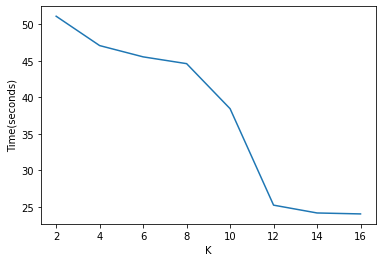

In [ ]:
K= [2,4,6,8,10,12,14,16]
selected_levels = [(1,2,5), (1,2,5), (1,2,5), (1,2,5), (1,2,5), (1,2,5), (1,2,5), (1,2,5)]
Time= [51.129866667, 47.10335798, 45.55694226999999, 44.625372146000004, 38.442761291000004, 25.209464654, 24.135795184000003, 24.00578066999999]

# Plot lists 'x' and 'y'
plt.plot(K, Time)

# Plot axes labels and show the plot
plt.xlabel('K')
plt.ylabel('Time(seconds)')
plt.show()


## Step 6-2

The algorithm is tested for db_100000, T=0, QI=3, 8 values for K and has resulted in the below values and Chart

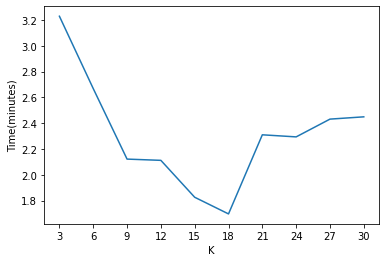

In [ ]:
K= [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
Time= [193.73777396800006, 160.09724564800013, 127.29233054300005, 126.709588682, 109.545261928, 101.79596704600002, 138.592935393, 137.624862378, 145.8872092219999, 146.95097781200002]

# Plot lists 'x' and 'y'
plt.plot(K, [t/60 for t in Time])
ax=plt.gca()
ax.locator_params('x', nbins=len(K))
plt.xticks(np.arange(min(K), max(K)+1, 3))
# Plot axes labels and show the plot
plt.xlabel('K')
plt.ylabel('Time(minutes)')
plt.show()

## Step 6-3

The algorithm is tested for Adults, T=1, QI=3 [age,occupation,race] with 10 values for K, and has resulted the below values and chart.

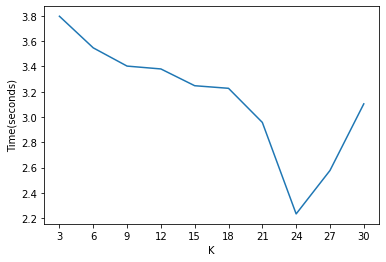

In [ ]:
K= [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
selected_levels = [(0,2,1), (1,2,1), (2,2,1), (2,2,1), (2,2,1), (2,2,1), (2,2,1), (2,2,1), (2,2,1), (2,2,1)]
Time= [3.7972470991190206, 3.5473701590009253, 3.4030999000816021, 3.3805389914096841, 3.2478894130000526, 3.2274009183835964, 2.9577501514017647, 2.2341403838349064, 2.5775057750439489, 3.1043998239999894]

# Plot lists 'x' and 'y'
plt.plot(K, Time)
plt.xticks(np.arange(min(K), max(K)+1, 3))

# Plot axes labels and show the plot
plt.xlabel('K')
plt.ylabel('Time(seconds)')
plt.show()

## Step 6-4

The algorithm is tested for Adults, K=3,T=1 and K=9,T=3

with QI subsets of size 2,3,4,5,6 from set [age, occupation, race, sex, native_country, marital_status]

and has resulted the below values and chart.

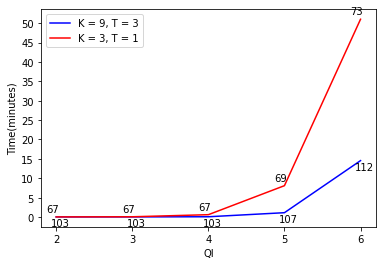

In [ ]:
QI= [2,3,4,5,6]
Time_9= [1.0514069999999833, 1.2799146579999956 ,3.520381200999992 ,66.348663548 ,872.401814215]
#selected_levels = [2, 1, 1, 1, 1, 1]

Time_3= [1.1867007230000013, 3.351826609999989, 35.581710586999975, 484.5678140949999, 3060.34522177999999] #12705.753914114
#selected_levels = [0, 2, 1, 1, 1, 0]

original_dropped_9 = [32562-32459, 32562-32459, 32562-32459, 32562-32455, 32562-32450]
original_dropped_3 = [32562-32495, 32562-32495, 32562-32495, 32562-32493, 32562-32489]

plt.clf()
plt.plot(QI,[t/60 for t in Time_9],"-b", label = "K = 9, T = 3")
plt.plot(QI,[t/60 for t in Time_3],'-r', label = "K = 3, T = 1")
# zip joins x and y coordinates in pairs
for x,y,z in zip(QI,[t/60 for t in Time_9],original_dropped_9):
    label = "{:d}".format(z)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(4,-9), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(QI,[t/60 for t in Time_3],original_dropped_3):
    label = "{:d}".format(z)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-4,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Plot axes labels and show the plot
#plt.text(x-0.4,y-0.3, "K=9", color='red', fontsize=10)
ax=plt.gca()
ax.locator_params('y', nbins=20)
ax.locator_params('x', nbins=len(QI))
plt.legend(loc="upper left")
plt.xlabel('QI')
plt.ylabel('Time(minutes)')
plt.show()